# core

> The core module provides a set of functions for exploratory data analysis

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sklearn.feature_selection as skfl

## Univariate analysis

In univariate analysis we explore each variable by itself

### Ratio variables

For ratio variables the function `plot_univariate_continuous` generates a single plot showing all the basic information needed to describe it

In [ ]:
#| export
def plot_univariate_continuous(df:pd.DataFrame, # Data
                               var:str, # Variable to plot
                               var_name:str, # Variable name
                               ax): # Axes on which to draw the plot
   
    ## Calculate the quantiles
    df_plot = df[[var]].copy()
    df_plot['qcut'] = pd.qcut(df_plot[var], [0, 0.25, 0.75, 1], labels=['1st', 'iqr', '4th'])
   
    # Define the plaette
    # color palette as dictionary
    palette = {"1st":"silver",
               "iqr":"gold",
               "4th":"silver"}
   
    # Create a density plot
    sns.histplot(data=df_plot,
                 x=var,
                 stat='percent',
                 ax=ax,
                 hue='qcut',
                 multiple='stack',
                 palette=palette)
   
   
    # Remove legend
    ax.get_legend().remove()
   
    # Add a vertical line at the mean
    var_mean = df[var].mean()
   
    ax.axvline(var_mean)
   
    # Add labels
    ax.set_xlabel(var_name, fontfamily='Century Gothic', fontsize=16)
    ax.set_ylabel('Percent', fontfamily='Century Gothic', fontsize=16)
   
    # Set tick font size
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_name('Century Gothic')
        label.set_size(12)
   
    return ax

To see the function in action we use the [diamonds](https://ggplot2.tidyverse.org/reference/diamonds.html) dataset provided with seaborn

In [ ]:
diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


This dataset only includes variables with two levels of measurement (ratio and ordinal), the variables can be classified as,

In [ ]:
diamonds_ratio = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
diamonds_ordinal = ['cut', 'color', 'clarity']

The density plot of the `carat` feature is

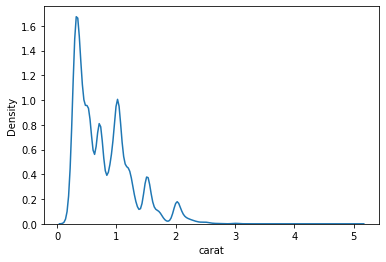

In [ ]:
sns.kdeplot(data=diamonds, x='carat');

We create an axis in the whitegrid style and call `plot_univariate_continuous`

findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.


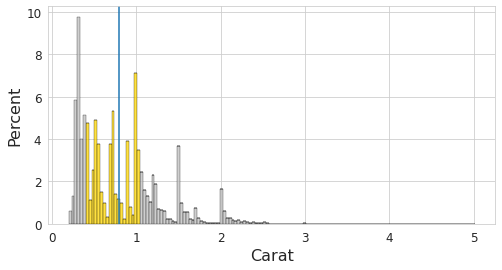

In [ ]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(8,4))
plot_univariate_continuous(diamonds, 'carat', 'Carat', ax);

The resulting figure shows an histogram plot made using `seaborn.histplot` with `stat='percent'`. It includes a vertical line drawn at the mean of the data and uses colors to distiguish three groups: the first quartile, the fourth quartile and the second and third quartile (together)

### Ordinal features

In [ ]:
#| hide
def plot_univariate_nominal(df:pd.DataFrame, # Data
                            var:str, # Variable to plot
                            var_name:str, # Variable name
                            ax): # Axes on which to draw the plot
    pass

Each of the ordinal features have the following categories ordered from best to worst,

In [ ]:
for feat in diamonds_ordinal:
    print(f'Categories in {feat}:')
    print(diamonds[feat].unique())
    print('\n')

Categories in cut:
['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']


Categories in color:
['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']


Categories in clarity:
['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']




## Bivariate analysis

The goal is a fuction that can calculate a measure of dependence between all the features in a given dataset.

In [ ]:
#| exporti
def rr_corr(df:pd.DataFrame, # Data
            ratio_vars:list): # Columns in `df` with ratio variables
    """
    Correlation between all pairs of ratio variables in `df`
    
    Uses the `corr` method of `pandas.DataFrame` 
    """
    
    # Extract ratio variables
    df_corr = df[ratio_vars].copy()
    
    # Calculate the correlation between ratio features in the dataset
    df_corr = df.corr()
    
    # Reshape into a table removing redundant pairs
    df_corr = df_corr.where(np.triu(np.ones(df_corr.shape), 1).astype(bool))
    df_corr = df_corr.stack().reset_index()
    df_corr.columns = ['feat_1', 'feat_2', 'value']
    df_corr['metric'] = "Pearson correlation coefficient"
    
    # Absolute value of correlation is used since we only search for association
    df_corr['assoc_strength'] = df_corr['value'].abs()
    df_corr['assoc_strength'] = pd.cut(df_corr['assoc_strength'], 
                                       bins=[0, 0.2, 0.5, 1], 
                                       labels=['weak', 'moderate', 'strong'])
    
    return df_corr.sort_values('assoc_strength', ascending=False)

In [ ]:
#| export
def strength_of_assoc(df:pd.DataFrame, # Data
                      ratio_vars:list=None, # Columns in `df` with ratio variables
                      ordinal_vars:list=None, # Columns in `df` with ordinal variables
                      nominal_vars:list=None, # Columns in `df` with nominal variables
                      binary_vars:list=None): # Columns in `df` with binary variables
    # Initialize results dataframe
    soa_df = []
    
    ## Calculate strength of association between different variables
    # Ratio - Ratio
    if ratio_vars:
        soa_df.append(rr_corr(df, ratio_vars))
    
    # Ratio - Ordinal
    # Ratio - Nominal
    # Ratio - Binary
    # Ordinal - Ordinal
    # Ordinal - Nominal
    # Ordinal - Binary
    # Nominal - Nominal
    # Nominal - Binary
    # Binary - Binary
    
    return pd.concat(soa_df)

We say a variable has a ratio [level of measurement](https://en.wikipedia.org/wiki/Level_of_measurement) if it is a  variable for which ratios are meaningful. Ratio variables have all the properties of interval variables plus a real absolute zero.

For the diamonds dataset we have

In [ ]:
diamonds_rcorr = strength_of_assoc(diamonds, diamonds_ratio)
diamonds_rcorr.head()

,feat_1,feat_2,value,metric,assoc_strength
20,y,z,0.952006,Pearson correlation coefficient,strong
2,carat,price,0.921591,Pearson correlation coefficient,strong
3,carat,x,0.975094,Pearson correlation coefficient,strong
4,carat,y,0.951722,Pearson correlation coefficient,strong
5,carat,z,0.953387,Pearson correlation coefficient,strong


`strength_of_assoc` returns the correlation between each of the `n (n - 1) / 2` pair of variables where `n` is the number of ratio variables

In [ ]:
assert len(diamonds_rcorr.index) == 21

In [ ]:
#| hide
def rb_corr(df:pd.DataFrame, # Data
            ratio_vars:list, # Columns in `df` with ratio variables
            binary_vars:list): # Columns in `df` with 2-level nominal variables (i.e. binary)
    
    bin_feat = df[binary_vars].copy()

In [ ]:
#| hide
def ro_corr(df:pd.DataFrame, # Data
            ratio_vars:list, # Columns in `df` with ratio variables
            ordinal_vars:list): # Columns in `df` with ordinal variables
    """
    
    All the ordinal variables must have an ordered category dtype
    """
    for ov in ordinal_vars:
        if not df[ov].cat.ordered:
            raise TypeError(f'{ov} is not ordered')
    

In [ ]:
#| hide
#ro_corr(diamonds, diamonds_ratio, diamonds_ordinal)

In [ ]:
#| export
def soa_graph(cdf:pd.DataFrame, # A dataframe as output by `ratio_corr`
               min_strength:str='strong'): # Threshold for high correlation
    
    # Filter values below min_strength (weak < moderate < strong)
    if min_strength == 'strong':
        filter_list = ['strong']
    elif min_strength == 'moderate':
        filter_list = ['moderate', 'strong']
    else:
        filter_list = ['weak', 'moderate', 'strong']
    
    high_soa = cdf[cdf.assoc_strength.isin(filter_list)].copy()
    
    # Sort for visualization
    high_soa = high_soa.sort_values(['assoc_strength', 'feat_1', 'feat_2'], ascending=False)
    
    # Generate the graph
    soa_graph = nx.from_pandas_edgelist(high_soa, 'feat_1', 'feat_2')
    for node in soa_graph.nodes():
        soa_graph.nodes[node]['label'] = node
            
    return high_soa, soa_graph

In [ ]:
diamonds_high_soa, diamonds_soa_graph = soa_graph(diamonds_rcorr)

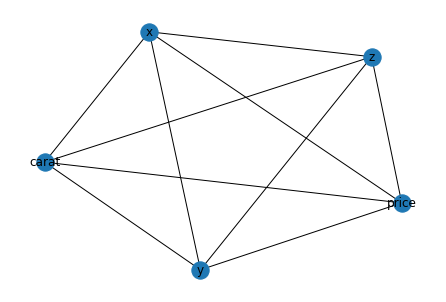

In [ ]:
nx.draw(diamonds_soa_graph, with_labels=True)

In [ ]:
#| hide
def continuous_mi(df:pd.DataFrame): # Data
    
    # Keep only numeric variables
    num_df = df.select_dtypes(include=[np.number]).copy()
    
    # Define the variables
    feats = num_df.columns.to_list()
    
    # Initialize
    dfs = list()
    
    for feat in feats:
        # Define columns to use
        subset_feat = feats.copy()
        #subset_feat.remove(feat)
        X = num_df[subset_feat].copy()
        y = num_df[feat].ravel()
        
        mi_Xy = skfl.mutual_info_regression(X, y)
        
        dfi = pd.DataFrame(data={'feat_1':subset_feat, 'feat_2':feat, 'mutual_info':mi_Xy})
        dfs.append(dfi)
        
    return pd.concat(dfs)
    
    

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()